# Imports

In [1]:
from collections import defaultdict
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import seaborn as sns
sns.set();
from statsmodels.stats.descriptivestats import sign_test
from scipy.stats import wilcoxon

from dpipe.io import load

In [2]:
meta = pd.read_csv('/gpfs/data/gpfs0/b.shirokikh/data/cc359/meta.csv', index_col='id')
meta.head()

,MRI,brain_mask,fold,tomograph_model,tesla_value,x,y,z
id,,,,,,,,
CC0030,images/CC0030_philips_15_42_F.nii.gz,masks/CC0030_philips_15_42_F_ss.nii.gz,4,philips,15,1.000008,0.888889,0.888889
CC0326,images/CC0326_ge_3_55_M.nii.gz,masks/CC0326_ge_3_55_M_ss.nii.gz,3,ge,3,1.000000,1.000000,1.000000
CC0187,images/CC0187_siemens_3_63_F.nii.gz,masks/CC0187_siemens_3_63_F_ss.nii.gz,1,siemens,3,1.329996,1.000000,1.000000
CC0114,images/CC0114_philips_3_60_M.nii.gz,masks/CC0114_philips_3_60_M_ss.nii.gz,5,philips,3,1.000000,1.000000,1.000000
CC0231,images/CC0231_siemens_3_56_M.nii.gz,masks/CC0231_siemens_3_56_M_ss.nii.gz,1,siemens,3,1.330005,1.000000,1.000000


### Choosing experiment & bins:

In [3]:
exp_oracle = Path('/gpfs/data/gpfs0/b.shirokikh/experiments/da/miccai2021_spottune/baseline/cc359_unet2d_oracle')
exp_base = Path('/gpfs/data/gpfs0/b.shirokikh/experiments/da/miccai2021_spottune/baseline/cc359_unet2d_one2all')

exp_stack_finetune = Path('/gpfs/data/gpfs0/b.shirokikh/experiments/da/miccai2021_spottune/finetune/')

n2folder = {'1/48': '1_48', '1/36': '1_36', '1/24': '1_24', '1/12': '1_12', '1/6': '1_6', '1/3': '1_3',
            '1': '1', '2': '2', '3': '3'}
n2label = {'1/48': '5', '1/36': '8', '1/24': '12', '1/12': '24', '1/6': '45', '1/3': '90',
            '1': '270', '2': '540', '3': '800'}

# The Plots

In [4]:
groups = list(n2folder.keys())

# exps = ['posttrain', 'unfreeze_first', 'spottune']
# exp2label = {e: l for e, l in zip(exps, ['Fine-tune All Layers', 'Fine-tune First Layers', 'SpotTUnet'])}
# exp2color = {e: c for e, c in zip(exps, ['#FFBF00', '#E83F6F', '#2274A5'])}

exps = ['posttrain', 'unfreeze_first']
exp2label = {e: l for e, l in zip(exps, ['Fine-tune All Layers', 'Fine-tune First Layers'])}
exp2color = {e: c for e, c in zip(exps, ['#FFBF00', '#E83F6F'])}

# exps = ['posttrain', 'unfreeze_first', 'unfreeze_last']
# exp2label = {e: l for e, l in zip(exps,
#                                   ['Fine-tune All Layers', 'Fine-tune First Layers', 'Fine-tune Last Layers'])}
# exp2color = {e: c for e, c in zip(exps, ['#FFBF00', '#E83F6F', '#2274A5'])}

In [5]:
def load_dice_stack_base(n, n_folds=6):
    stack = []
    for i in range(n_folds):
        dices = load(exp_base / f'experiment_{i}/test_metrics/sdice_score.json')
        for j in range(n_folds - 1):
            pair_ids = sorted(list(load(exp_stack_finetune /
                f'{n2folder[n]}/posttrain/experiment_{i * (n_folds - 1) + j}/test_metrics/sdice_score.json'
            ).keys()))
            stack.append(np.array([dices[_id] for _id in pair_ids]))
    return stack

d_base = {n: {e: load_dice_stack_base(n) for e in exps} for n in groups}

In [6]:
def load_dice_stack_oracle(n, n_folds=6):
    stack = []
    for i, i_cv in enumerate([i for f in range(n_folds) for i in set(range(6)) - {f}]):
        dices = {}
        for j in range(3):
            dices = {**dices, **load(exp_oracle / f'experiment_{i_cv * 3 + j}/test_metrics/sdice_score.json')}
        pair_ids = sorted(list(load(exp_stack_finetune /
            f'{n2folder[n]}/posttrain/experiment_{i}/test_metrics/sdice_score.json'
        ).keys()))
        stack.append(np.array([dices[_id] for _id in pair_ids]))
    return stack

d_oracle = {n: {e: load_dice_stack_oracle(n) for e in exps} for n in groups}

In [7]:
def load_dice_stack(exp, n, n_folds=6):
    path = str(exp_stack_finetune / n2folder[n] / exp / 'experiment_{}/test_metrics/sdice_score.json')
        
    stack = []
    for i in range(n_folds * (n_folds - 1)):
        dices = load(path.format(i))
        stack.append(np.array([dices[_id] for _id in sorted(list(dices.keys()))]))
    return stack

d = {n: {e: load_dice_stack(e, n) for e in exps} for n in groups}

In [8]:
d_means = {n: {e: [np.mean(arr) for arr in d[n][e]] for e in exps} for n in groups}
d_base_means = {n: {e: [np.mean(arr) for arr in d_base[n][e]] for e in exps} for n in groups}
d_oracle_means = {n: {e: [np.mean(arr) for arr in d_oracle[n][e]] for e in exps} for n in groups}

In [9]:
d_rel = {n: 
            {e: 
                [(s1 - s2) / (s3 - s2) for s1, s2, s3 in 
                 zip(d[n][e], d_base[n][e], d_oracle[n][e])]
                for e in exps
            }
            for n in groups
        }

In [10]:
d_rel_means = {n: 
            {e: 
                [(s1 - s2) / (s3 - s2) for s1, s2, s3 in 
                 zip(d_means[n][e], d_base_means[n][e], d_oracle_means[n][e])]
                for e in exps
            }
            for n in groups
        }

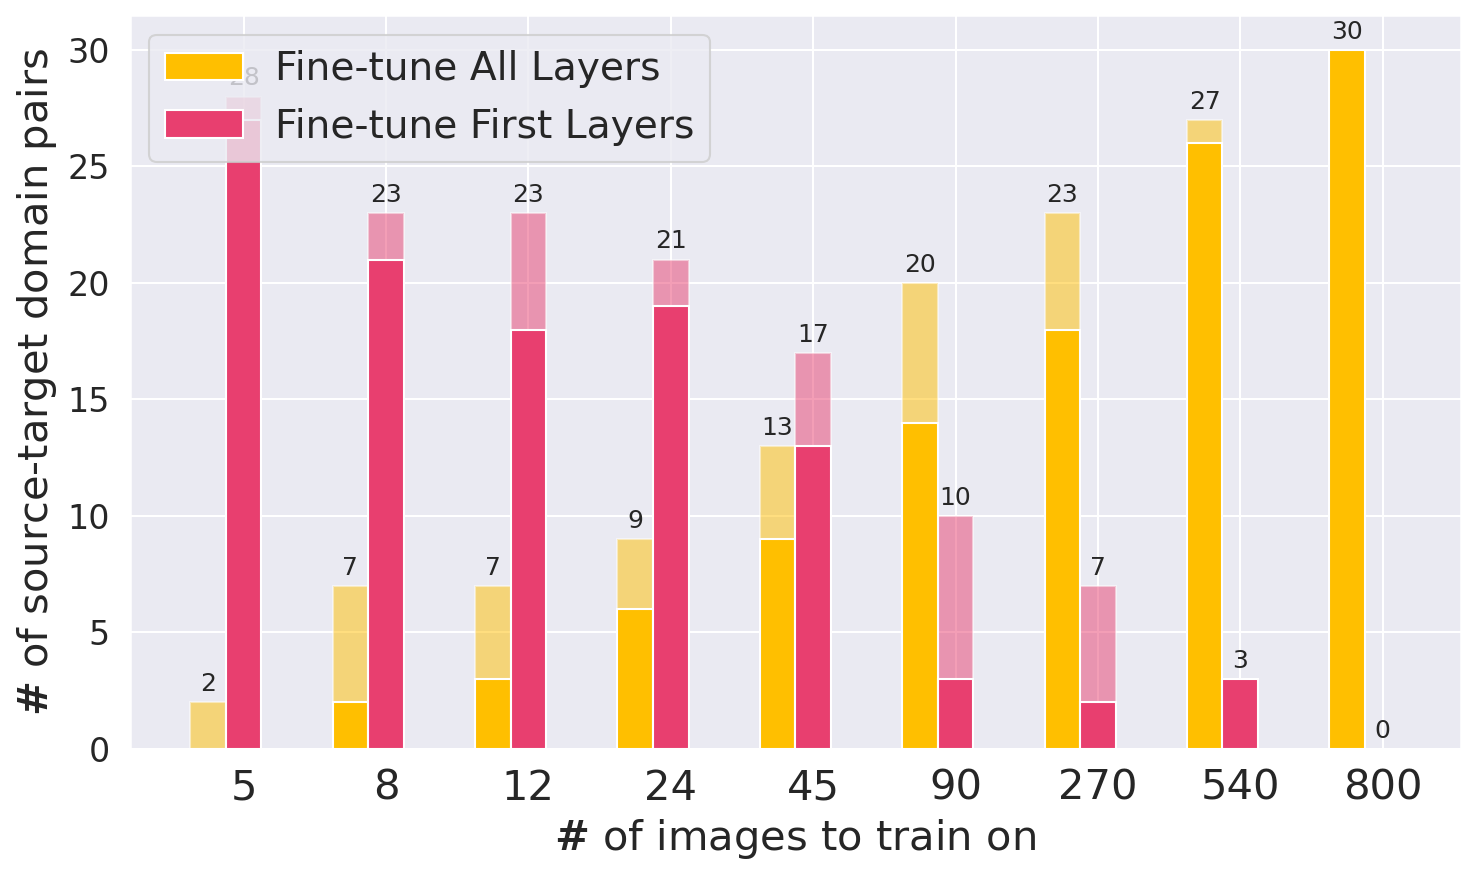

In [11]:
xs = np.arange(len(d))

n_winners = defaultdict(list)
n_winners_strong, p_th = defaultdict(list), 0.05
for n in groups:
    for e in exps:
        n_winners[e].append(0)
        n_winners_strong[e].append(0)
    for i_exp, values in enumerate(zip(*[d_rel_means[n][e] for e in exps])):
        srt_idx = sorted(range(len(values)), key=lambda i: values[i], reverse=True)
        n_winners[exps[srt_idx[0]]][-1] += 1
        arr = d_rel[n][exps[srt_idx[0]]][i_exp] - d_rel[n][exps[srt_idx[1]]][i_exp]
        if sign_test(arr)[-1] < p_th:
            n_winners_strong[exps[srt_idx[0]]][-1] += 1

w = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
rects = [ax.bar(xs + (i - 1) * w, n_winners[e], width=w, color=exp2color[e], alpha=0.5)
         for i, e in enumerate(exps)]
rects_p = [ax.bar(xs + (i - 1) * w, n_winners_strong[e], width=w, color=exp2color[e], label=exp2label[e])
           for i, e in enumerate(exps)]

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\mathbf{\#}$ of source-target domain pairs', fontsize=20)
ax.set_xlabel('$\mathbf{\#}$ of images to train on', fontsize=20)
ax.set_xticks(xs)
ax.set_xticklabels(list(n2label.values()), fontsize=20)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='upper left', fontsize=18.8)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


for rect in rects:
    autolabel(rect)

fig.tight_layout()

plt.show()

In [12]:
# remove validation:
n_first_val = 5
d_means = {n: {e: [np.mean(arr) for arr in d[n][e]][n_first_val:] for e in exps} for n in groups}
d_base_means = {n: {e: [np.mean(arr) for arr in d_base[n][e]][n_first_val:] for e in exps} for n in groups}
d_oracle_means = {n: {e: [np.mean(arr) for arr in d_oracle[n][e]][n_first_val:] for e in exps} for n in groups}

In [ ]:
# test separate validations:
# select_val = 5
# val_slice = slice(select_val * 5, (select_val + 1) * 5)

# d_means = {n: {e: [np.mean(arr) for arr in d[n][e]][val_slice] for e in exps} for n in groups}
# d_base_means = {n: {e: [np.mean(arr) for arr in d_base[n][e]][val_slice] for e in exps} for n in groups}
# d_oracle_means = {n: {e: [np.mean(arr) for arr in d_oracle[n][e]][val_slice] for e in exps} for n in groups}

In [13]:
df_to_vis = []
i = 0
for n in groups:
    sdict = d_means[n]
    for e in exps:
        arr = sdict[e]
        for sdsc in arr:
            df_to_vis.append({'id': i, 'n_data': n2label[n], 'sdsc': sdsc, 'exp': exp2label[e]})
            i += 1
df_to_vis = pd.DataFrame.from_records(df_to_vis, index='id')

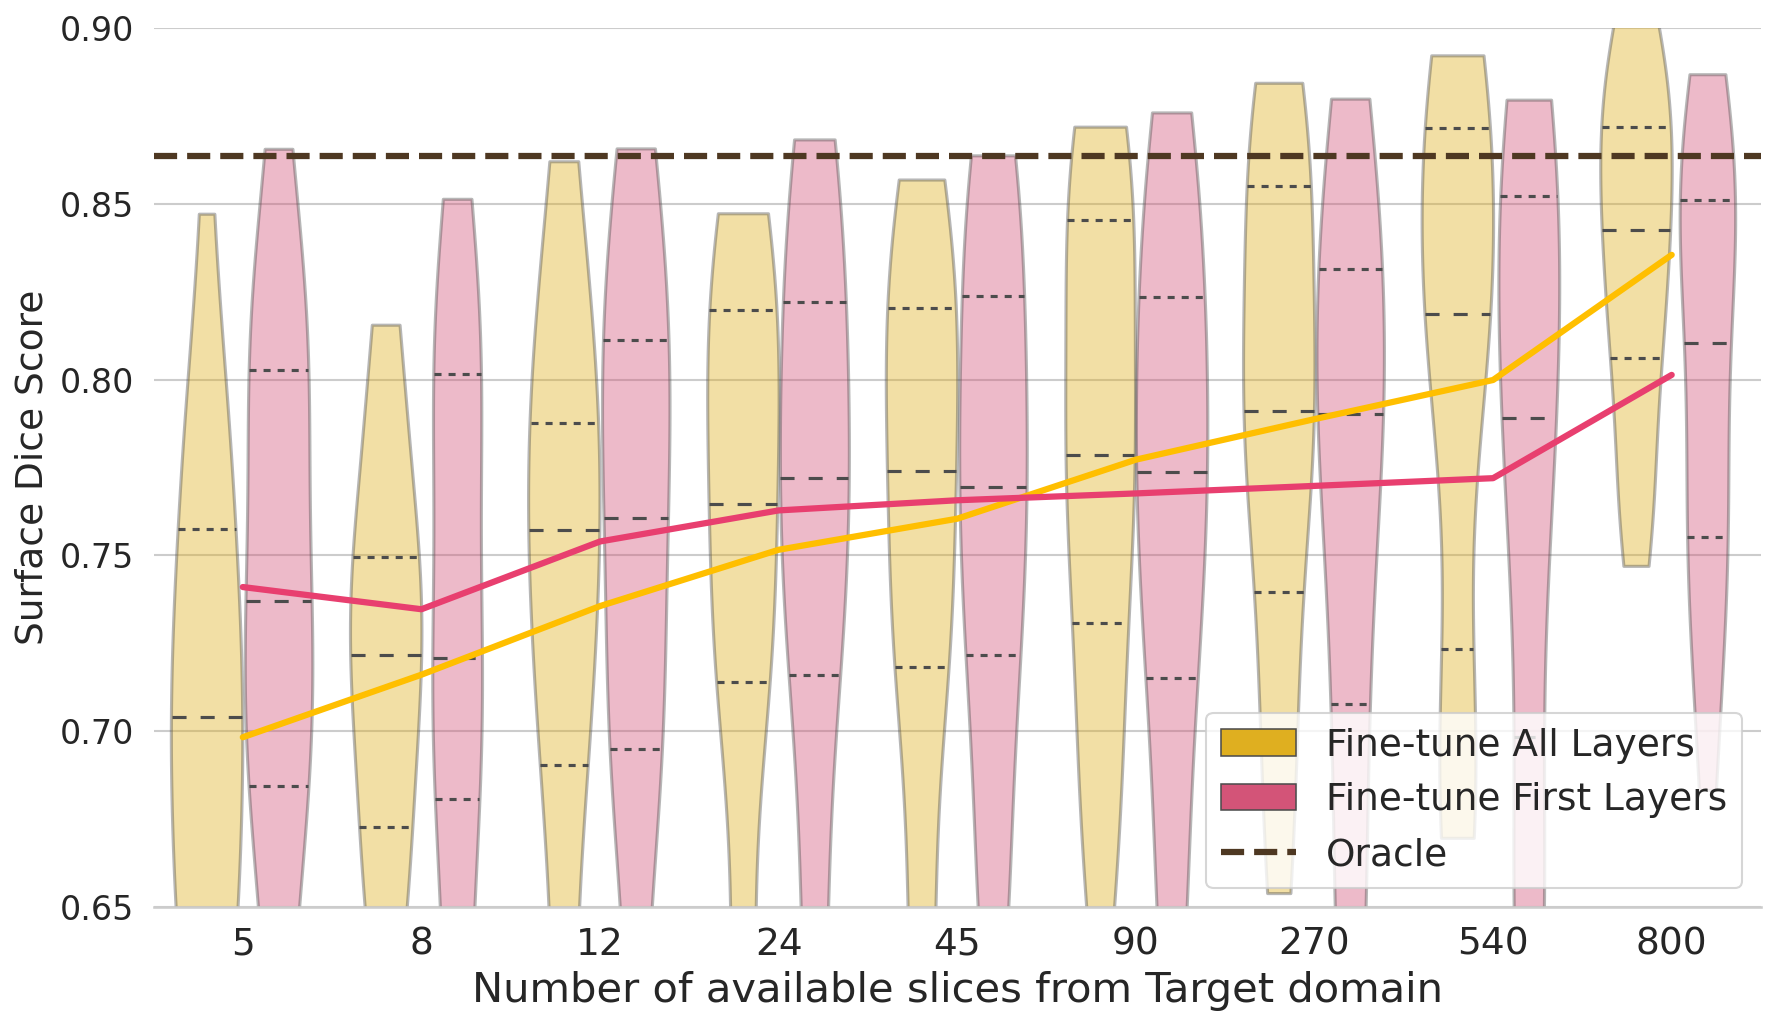

In [14]:
sns.set(style="whitegrid", palette="pastel", color_codes=True);
# sns.set(palette="pastel", color_codes=True);

fig, ax = plt.subplots(figsize=(12, 7), dpi=150)

sns.violinplot(x='n_data', y='sdsc', hue='exp', inner='quart', data=df_to_vis, cut=0,
               palette={e: c for e, c in zip(exp2label.values(), exp2color.values())})
sns.despine(left=True)

plt.setp(ax.collections, alpha=.4)

plt.ylim((0.65, 0.9))

# plt.ylabel('delta (transfering) / delta (oracle)', fontsize=18)
ax = plt.gca()
ax.set_ylabel('Surface Dice Score', fontsize=18)

# plt.xlabel('# of images to train on', fontsize=20)
ax.set_xlabel('Number of available slices from Target domain', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)

for e in exps:
    arr = np.array([np.mean(d_means[n][e]) for n in groups])
    plt.plot(np.arange(len(groups)), arr, color=exp2color[e], linewidth=3)
    
global_mean_b = np.mean(d_base_means['1']['posttrain'])
global_mean_o = np.mean(d_oracle_means['1']['posttrain'])
# plt.plot(np.arange(len(groups)), [global_mean_b] * len(groups), color='black', linewidth=5)
# plt.plot(np.arange(len(groups)), [global_mean_o] * len(groups), color='black', linewidth=2, linestyle='--')

plt.hlines(global_mean_o, -0.5, len(groups), colors='#4E3822', linestyle='--', linewidth=3)
plt.xlim((-0.5, len(groups) - 0.5))

handles, labels = ax.get_legend_handles_labels()
line_oracle = Line2D([0], [0], color='#4E3822', linewidth=3, linestyle='--', label='Oracle')
handles.append(line_oracle)
plt.legend(handles=handles, loc='lower right', fontsize=18)
    
# plt.xticks(ticks=np.arange(len(d)), labels=list(n2folder.keys()))

plt.tight_layout()
plt.show()

## [TODO] Just comparing mean values of Histogram Matching (HM) and baseline

In [15]:
# d_hm = {n: {e: load_dice_stack(e, n) for e in ('hm', )} for n in groups}
# d_means_hm = {n: {e: np.mean([np.mean(arr) for arr in d_hm[n][e]][n_first_val:]) for e in ('hm', )} for n in groups}

In [16]:
# d_means_hm

In [17]:
# global_mean_b

## [TODO] Varying regularization

In [18]:
k_regs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.012, 0.015, 0.02]
k_regs = {0: '0', 0.001: '0_001', 0.003: '0_003', 0.005: '0_005',
          0.007: '0_007', 0.01: '0_01', 0.012: '0_012', 0.015: '0_015', 0.02: '0_02'}
# k_reg_path_template = \
# '/gpfs/data/gpfs0/i.zakazov/experiments/spottune/{}/layerwise5pairs/spottune/k_{}/experiment_{}/test_metrics/sdice_score.json'
k_reg_path_template = \
'/gpfs/data/gpfs0/b.shirokikh/experiments/da/miccai2021_spottune/k_reg/k_{}/{}/experiment_{}/test_metrics/sdice_score.json'
k_reg_path_template_new = \
'/gpfs/data/gpfs0/b.shirokikh/experiments/da/miccai2021_spottune/k_reg/k_{}/{}_new/experiment_{}/test_metrics/sdice_score.json'

In [19]:
sdices, sdices_mean = defaultdict(list), defaultdict(list)
for n in groups:
    for k in list(k_regs.values()):
        sdsc = {}
        for i in range(5):  # n_val
            try:
                sdsc = {**sdsc, **load(k_reg_path_template_new.format(k, n2folder[n], i))}
            except FileNotFoundError:
                sdsc = {**sdsc, **load(k_reg_path_template.format(k, n2folder[n], i))}
        sdices_mean[n].append(np.mean(list(sdsc.values())))
        sdices[n].append(list(sdsc.values()))

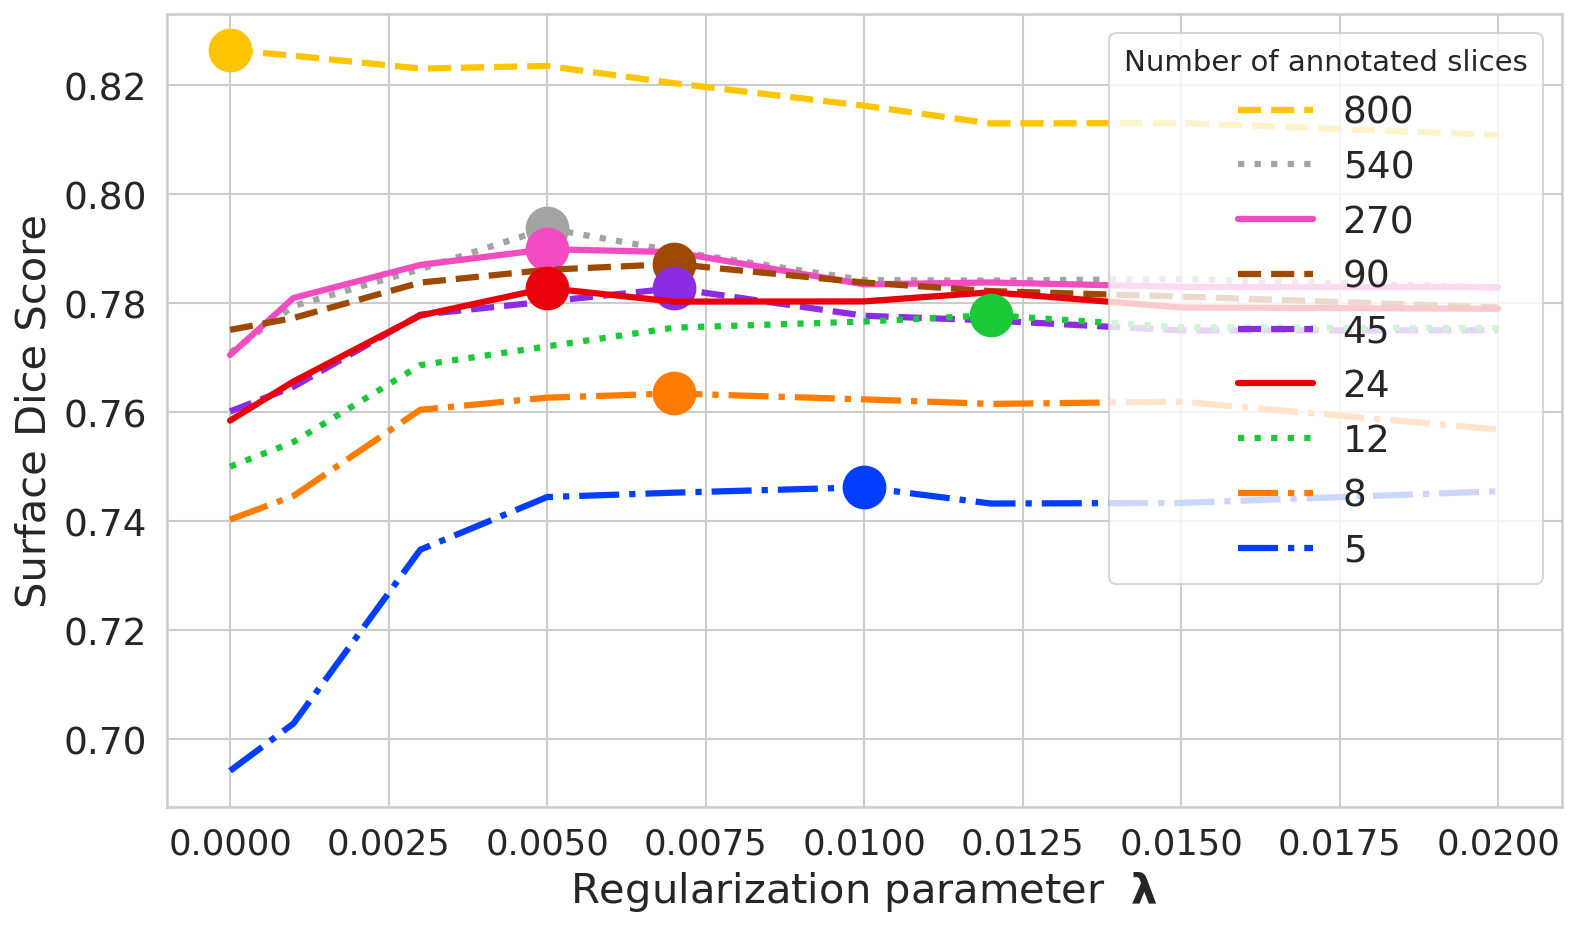

In [20]:
sns.set(style="whitegrid", palette="pastel", color_codes=True);
# sns.set(palette="pastel", color_codes=True);

fig, ax = plt.subplots(figsize=(12, 7), dpi=150)

ax = plt.gca()
ax.set_ylabel('Surface Dice Score', fontsize=20)

# plt.xlabel('# of images to train on', fontsize=20)
ax.set_xlabel('Regularization parameter  $\mathbf{\lambda}$', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=18)

colors = sns.color_palette("bright", n_colors=len(sdices))
lss = ('-.', '-.', ':', '-', '--', '--', '-', ':', '--')

for i, (ls ,c, (n, arr)) in enumerate(zip(lss[::-1], colors[::-1], list(sdices_mean.items())[::-1])):
    a = np.argmax(arr)
    ax.plot(list(k_regs.keys()), arr, linewidth=3, label=n2label[n], color=c, linestyle=ls)
    ax.plot(list(k_regs.keys())[a], arr[a], 'o', color=c, markersize=20)
    
plt.legend(loc='upper right', fontsize=18, title='Number of annotated slices', title_fontsize=14)
plt.show()

In [21]:
for n, arr in sdices_mean.items():
    a_top = np.argsort(arr)[-1]
    try:
        print(n, wilcoxon(sdices[n][a_top], sdices[n][0], alternative='greater'))
    except ValueError:
        print(n, "The optimal k_reg is 0.")

1/48 WilcoxonResult(statistic=40683.0, pvalue=4.496482477896685e-39)
1/36 WilcoxonResult(statistic=38725.0, pvalue=7.928742968935023e-32)
1/24 WilcoxonResult(statistic=39870.0, pvalue=5.702473735025889e-36)
1/12 WilcoxonResult(statistic=41059.0, pvalue=1.4871333308842028e-40)
1/6 WilcoxonResult(statistic=40561.0, pvalue=1.3399608659437733e-38)
1/3 WilcoxonResult(statistic=32097.0, pvalue=4.720699545019484e-13)
1 WilcoxonResult(statistic=31713.0, pvalue=3.0949597023187127e-12)
2 WilcoxonResult(statistic=34298.0, pvalue=2.6424840368996754e-18)
3 The optimal k_reg is 0.
